# Set-up

In [2]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from lxml import etree
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble \
import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
import timeit
import itertools
import pickle
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constantes et fonctions

In [52]:
DICT_COLS = {'Title': [300, 1500, 500], 'Body': [500, 3000, 1000]}
SAMPLE = 5000
RATIO = 1/3

def tag_question(title, body):
    """
    Prediction function of stackexchange tags from a query passed as parameter
    """ 

    RATIO = 1/3
    REGEX = '[a-z0-9]+[#-]?\+{0,2}[a-z0-9]*'

    # Stopwords nltk 
    std_sw = set(nltk.corpus.stopwords.words('english')) 

    # Extra stopwords = radicaux qui ne me semblent pas discriminants 
    extra_sw = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
                'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
                'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb')


    tokenizer = nltk.RegexpTokenizer(REGEX)
    lemmatizer = WordNetLemmatizer() 
    stemmer = PorterStemmer()

    with open('OC_DS_P6_prod.pkl', 'rb') as file:
        unpickler = pickle.Unpickler(file)
        sclr = unpickler.load()
        tfidf = unpickler.load()
        mod = unpickler.load()
        lbl = unpickler.load()

    title = clean_field(title, tknzr=tokenizer, sw=std_sw, \
                        lmtzr=lemmatizer, stmr=stemmer)
    title = ' '.join([w for w in title.split() \
                       if w not in extra_sw and not w.isdigit()])

    body = clean_field(body, tknzr=tokenizer, sw=std_sw, \
                       lmtzr=lemmatizer, stmr=stemmer)
    body = ' '.join([w for w in body.split() \
                      if w not in extra_sw and not w.isdigit()])
    
    tfidf_q = tfidf['Title'].transform([title])
    cols = tfidf['Title'].get_feature_names()
    tfidf_q = pd.DataFrame(tfidf_q.todense().tolist(), columns=cols)

    tfidf_b = tfidf['Body'].transform([body])
    cols = tfidf['Body'].get_feature_names()
    tfidf_b = pd.DataFrame(tfidf_b.todense().tolist(), columns=cols)

    X = (RATIO * tfidf_q).add((1 - RATIO) * tfidf_b, fill_value=0).fillna(0)

    return '<{}>'.format('><'.\
                         join(lbl.inverse_transform(mod.predict(sclr.transform(X))).\
                                                    split()))
    
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

# Chargement

In [5]:
with open('OC_DS_P6_backup.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    source = unpickler.load()
    EXTRA_SW = unpickler.load()
    REGEX = unpickler.load()

source.head()

,Title,Body,full,top_tags
59549234,determin divisor string,question job interview part problem mind probl...,determin divisor string question job interview...,algorithm string
59549281,trait object contain method return refer self,correct trait object contain method return ref...,trait object contain method return refer self ...,rust
59549471,function declar put insid return statement,function declar besid return statement functio...,function declar put insid return statement fun...,javascript
59549568,valu input react,track valu two login input field valu chang va...,valu input react track valu two login input fi...,css javascript react-hooks reactjs
59549600,assign vector type,assign member vector type,assign vector type assign member vector type,c++ c++11 multithreading


In [30]:
for col in ['Title', 'Body']:
    n = len(set(' '.join(train[col]).split()))
    print('{} : {} mots distincts'.format(col, n))

Title : 14628 mots distincts
Body : 54554 mots distincts


In [6]:
train = source.copy()
print('{} groupes de tags, {} unitaires'\
      .format(len(train.top_tags.unique()), \
              len(set(' '.join(train.top_tags).split()))))

3160 groupes de tags, 100 unitaires


# TF-IDF
Je crée un dictionnaire avec les vecteurs TFIDF pour les appeler dans la fonction finale

In [33]:
dict_tfidf = defaultdict(dict)

for col in DICT_COLS.keys():
    X = train[col]

    dict_tfidf['vector'][col] = TfidfVectorizer(token_pattern=REGEX, \
                                                stop_words=EXTRA_SW, \
                                                #min_df=DICT_COLS[col][0], \
                                                #max_df=DICT_COLS[col][1], \
                                                max_features=DICT_COLS[col][2]).fit(X)
                                                #DICT_COLS[col][2])
                                                
    #v_tfidf = dict_tfidf['vector'][col].transform(X)
    cols = dict_tfidf['vector'][col].get_feature_names()
    #dict_tfidf['df'][col] = pd.DataFrame(v_tfidf.todense().tolist(), \
    #                                     columns=cols, index=train.index)
    #print(col, ':', dict_tfidf['df'][col].shape)
    print(len(cols), cols)

500 ['2d', 'access', 'across', 'action', 'activ', 'address', 'aggreg', 'algorithm', 'altern', 'android', 'angular', 'anim', 'annot', 'anoth', 'api', 'app', 'append', 'applic', 'argument', 'array', 'asp', 'assign', 'async', 'attribut', 'authent', 'avoid', 'aw', 'await', 'awk', 'axi', 'azur', 'b', 'background', 'bar', 'base', 'bash', 'batch', 'behavior', 'behaviour', 'binari', 'bind', 'block', 'boolean', 'boot', 'bootstrap', 'box', 'branch', 'break', 'browser', 'build', 'button', 'byte', 'c', 'c#', 'c++', 'calcul', 'call', 'callback', 'cannot', 'captur', 'case', 'cast', 'caus', 'cell', 'chang', 'char', 'charact', 'chart', 'check', 'checkbox', 'child', 'chrome', 'class', 'claus', 'click', 'client', 'cloud', 'code', 'collect', 'color', 'column', 'combin', 'comma', 'command', 'commit', 'compar', 'compil', 'compon', 'comput', 'concaten', 'condit', 'configur', 'connect', 'consol', 'const', 'constraint', 'constructor', 'contain', 'content', 'context', 'control', 'convers', 'convert', 'copi', '

# Clustering

## Title

In [14]:
X = dict_tfidf['vector']['Title'].transform(train.Title)
X.shape

(46397, 135)

### PCA

In [15]:
pca = decomposition.PCA(n_components=2)

X_trans = pca.fit_transform(X.todense())

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.0190596  0.01715345] 0.036213049225303176


best clustering =  1400 elapsed :  1258.3286278790001


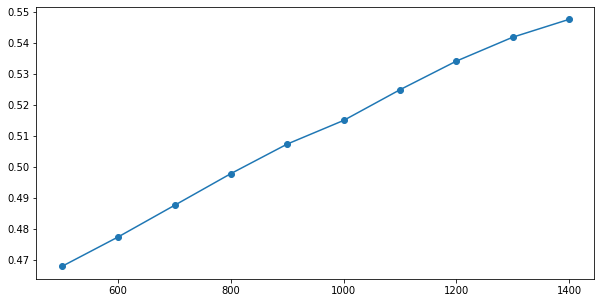

In [18]:
# Iteration de clustering kmeans avec des nb de clusters différents
silhouettes = []
cluster_range = range(500, 1500, 100)

start_time = timeit.default_timer()
for n in cluster_range:
    myclust = cluster.KMeans(n_clusters=n, random_state=1)
    myclust.fit(X)
    silhouettes.append(metrics.silhouette_score(X, myclust.labels_))

elapsed = timeit.default_timer() - start_time
best_cluster = cluster_range[np.argmax(silhouettes)]
print('best clustering = ', best_cluster, 'elapsed : ', elapsed)

fig = plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouettes, marker='o')

In [ ]:
nb_clusters = best_cluster
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters, random_state=1)
myclust.fit(X)

# Puis on visualise 
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
#plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
#plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Attempting to set identical left == right == -0.0 results in singular transformations; automatically expanding.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Attempting to set identical bottom == top == -0.0 results in singular transformations; automatically expanding.


Silhouette Coefficient: 0.888


In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = dict_tfidf['df']['Title'].assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789
0,61,1998,127,104,12,85,56,92,51,75,91,77,53,56,101,43,59,47,90,8,53,46,10,69,33,19,50,36,15,1,38,1,24,11,8,23,1,5,7,5,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
tfidf[tfidf.cluster == 4][['cluster']].merge(train[['Title', 'top_tags']], left_index=True, right_index=True)

,cluster,Title,top_tags
60902902,4,column valu quantil argument,dataframe r
61063753,4,sequenc column valu,r
60618799,4,subtract valu column groupbi,pandas pandas-groupby python
60313321,4,calcul percentag valu column group month year,mysql
60645405,4,extract part column valu mutat,r tidyverse
60427285,4,tidi dataset column dummi variabl cell valu na...,r
59828082,4,column valu name,pandas python
61263962,4,pick occur valu column name,pandas
60943666,4,boolean renam valu column,dataframe pandas python
59935993,4,vector numpi column valu condit,numpy python


# Classification supervisée

In [41]:
DICT_CLF = {'svm': {'name': 'Support Vector Machine',
                     'clf': LinearSVC() ,
                     'params': {'C': np.logspace(-3, 3, 7),
                                'loss': ['hinge','squared_hinge'],
                                'penalty': ['l1', 'l2']}},
            'knn': {'name': 'k-Nearest Neighbors',
                     'clf': KNeighborsClassifier(),
                     'params': {'n_neighbors': np.arange(10, 100, 10)}}, 
            'sgd': {'name': '', 'clf': SGDClassifier()}
            }

In [33]:
"""
            'rfc': {'name': 'Random Forrest',
                     'clf': RandomForestClassifier(),
                     'params': {'criterion': ['entropy', 'gini'],
                                'n_estimators': [20, 40, 60, 80, 100],
                                'max_features':['sqrt', 'log2']}}, 
"""

"\n            'rfc': {'name': 'Random Forrest',\n                     'clf': RandomForestClassifier(),\n                     'params': {'criterion': ['entropy', 'gini'],\n                                'n_estimators': [20, 40, 60, 80, 100],\n                                'max_features':['sqrt', 'log2']}}, \n"

## Multi-labelisation des top tags

In [34]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train.top_tags.str.split())
y = multilabel_binarizer.transform(train.top_tags.str.split())
y.shape

(46397, 100)

## Title

In [35]:
X = dict_tfidf['vector']['Title'].transform(train.Title)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32477, 500), (13920, 500), (32477, 100), (13920, 100))

In [48]:
dict_precision = {}

for k, v in DICT_CLF.items():
    clf = OneVsRestClassifier(v['clf'])
    clf_name = v['clf'].__class__.__name__
    print('{}\n{}\n{}'.format('='*30, clf_name, '-'*30))
    dict_precision[clf_name] = {}

    start_time = timeit.default_timer()
#    gs = GridSearchCV(clf, v['params'], cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
#    print("Best params:", gs.best_params_, '\n')
    dict_precision[clf_name]['clf'] = clf

    y_pred = clf.predict(X_test)
    precision = 100*metrics.accuracy_score(y_test, y_pred).round(2)
    dict_precision[clf_name]['precision'] = precision
    print("Precision: {:.2f} % \n".format(precision))

    elapsed = timeit.default_timer() - start_time

    accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
    print(col, ": accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

LinearSVC
------------------------------
Precision: 25.00 % 

Body : accuracy 25.00% time 6.84s

KNeighborsClassifier
------------------------------
Precision: 17.00 % 

Body : accuracy 17.00% time 839.67s



In [49]:
clf = RandomForestClassifier()
clf_name = clf.__class__.__name__
print('{}\n{}\n{}'.format('='*30, clf_name, '-'*30))
dict_precision[clf_name] = {}

start_time = timeit.default_timer()
#    gs = GridSearchCV(clf, v['params'], cv=5, scoring='accuracy')
clf.fit(X_train, y_train)
#    print("Best params:", gs.best_params_, '\n')
dict_precision[clf_name]['clf'] = clf

y_pred = clf.predict(X_test)
precision = 100*metrics.accuracy_score(y_test, y_pred).round(2)
dict_precision[clf_name]['precision'] = precision
print("Precision: {:.2f} % \n".format(precision))

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print(col, ": accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

RandomForestClassifier
------------------------------
Precision: 25.00 % 

Body : accuracy 25.00% time 239.12s



## Full

In [50]:
X_title = dict_tfidf['vector']['Title'].transform(train.Title)
X_body = dict_tfidf['vector']['Body'].transform(train.Body)
X = np.hstack([X_title, X_body])
X.shape

(2,)

In [54]:
dict_precision = {}

for k, v in DICT_CLF.items():
    clf = OneVsRestClassifier(v['clf'])
    clf_name = v['clf'].__class__.__name__
    print('{}\n{}\n{}'.format('='*30, clf_name, '-'*30))
    dict_precision[clf_name] = {}

    start_time = timeit.default_timer()
#    gs = GridSearchCV(clf, v['params'], cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
#    print("Best params:", gs.best_params_, '\n')
    dict_precision[clf_name]['clf'] = clf

    y_pred = clf.predict(X_test)
    elapsed = timeit.default_timer() - start_time

    precision = 100*metrics.accuracy_score(y_test, y_pred)
    print("Title+Body: time {:.2f}s".format(elapsed))    
    print("Accuracy: {:.2f}%".format(precision))    
    print("Jacard score: {:.2f}\n".format(avg_jacard(y_test, y_pred)))

    dict_precision[clf_name]['precision'] = precision

LinearSVC
------------------------------
Title+Body: accuracy 25.00% time 6.91s
Jacard score: 38.64

KNeighborsClassifier
------------------------------
Title+Body: accuracy 17.00% time 793.88s
Jacard score: 28.53



In [57]:
clf = RandomForestClassifier()
clf_name = clf.__class__.__name__
print('{}\n{}\n{}'.format('='*30, clf_name, '-'*30))
dict_precision[clf_name] = {}

start_time = timeit.default_timer()
#    gs = GridSearchCV(clf, v['params'], cv=5, scoring='accuracy')
clf.fit(X_train, y_train)
#    print("Best params:", gs.best_params_, '\n')
dict_precision[clf_name]['clf'] = clf

y_pred = clf.predict(X_test)
elapsed = timeit.default_timer() - start_time

precision = 100*metrics.accuracy_score(y_test, y_pred)
print("Title+Body: time {:.2f}s".format(elapsed))    
print("Accuracy: {:.2f}%".format(precision))    
print("Jacard score: {:.2f}\n".format(avg_jacard(y_test, y_pred)))

dict_precision[clf_name]['precision'] = precision

RandomForestClassifier
------------------------------
Title+Body: time 242.76s
Accuracy: 25.19%
Jacard score: 39.29



# LDA

In [ ]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern=REGEX,  
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(train.Title)
data_vectorized.shape

In [ ]:
#instantiate CountVectorizer() 
cv = CountVectorizer()
 
# this steps generates word counts for the words in your docs 
TF = cv.fit_transform(train.Title, train.Body)

In [ ]:
TF

<10000x3573 sparse matrix of type '<class 'numpy.int64'>'
	with 38866 stored elements in Compressed Sparse Row format>


        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0

In [ ]:
params = {'n_components' : np.arange(500, 5000, 500), 'learning_decay': [.5, .7, .9]}
clf = LatentDirichletAllocation()

print('{}\n{}\n{}'.format('='*30, 'lda', '-'*30))
dict_precision["lda"] = {}

gs = GridSearchCV(clf, params)
gs.fit(TF)

print("Best params:", gs.best_params_, '\n')
dict_precision["lda"]['clf'] = gs

lda
------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:790: RuntimeWarning: overflow encountered in exp
  return np.exp(-1.0 * perword_bound)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_ld

Best params: {'learning_decay': 0.5, 'n_components': 10} 



In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, cv.get_feature_names(), no_top_words)

NameError: ignored

# Export

In [ ]:
with open('OC_DS_P6_prod.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL) 
    pickler.dump(std_scale)
    pickler.dump(dict_tfidf['vector'])
    pickler.dump(gs)
    pickler.dump(lbl)    

# Test

In [ ]:
std_sw = set(nltk.corpus.stopwords.words('english')) 

# Extra stopwords = radicaux qui ne me semblent pas discriminants 
extra_sw = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
            'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
            'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb')


tokenizer = nltk.RegexpTokenizer(REGEX)
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

with open('OC_DS_P6_prod.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    sclr = unpickler.load()
    tfidf = unpickler.load()
    mod = unpickler.load()
    lbl = unpickler.load()

In [ ]:
tag_question('track 3rd parti code git', 'seem grok differ solut found studi track exter')